# <span style="color: Blue; ">kaggleの住宅価格予測（House Prices)</span>
## 使用するデータ
https://www.kaggle.com/c/house-prices-advanced-regression-techniques
- 81の説明変数から住宅の価格を予測する
- 決定木のアンサンブル学習や勾配ブースティングをメインとするが、線形でも精度を試す

## 使用外部ライブラリ


- matplotlib==3.1.3
- seaborn==0.10.0
- scipy==1.4.1
- numpy==1.18.1
- pandas==1.0.1
- scikit-learn==0.22.1
- lightgbm==2.3.1

## ■dataの読み込み
- 使用する外部ライブラリーをインポート
- ファイル読み込みを行う
- trainデータの'SalePrice'を学習用データのラベルとする
- trainデータとtestデータを同じ条件で前処理を行うため統一する
- 共通の処理が終わったらまた、元に戻すためtraintest列を作成して、trainデータにはtrain、testデータにはtestデータを入力する
- グラフで目的変数を確認するためのalldataprice、提出用のidを用意する

In [97]:
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import skew,pearsonr
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import lightgbm as lgb
from sklearn.metrics import r2_score,mean_squared_error

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
y_train = train["SalePrice"]
train["traintest"] ="train"
test["traintest"] ="test"
alldata = pd.concat([train,test], axis=0, sort=False)
traintest = alldata["traintest"]
alldataprice = alldata["SalePrice"]
submissioonid= test['Id']

## ■infoで説明変数のデータを確認
- データのtypeと欠損値を確認する
- データの種類はobjectデータとintデータ、floatデータ
- 欠損データも含まれている

In [98]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

## 学習データのラベル確認
- ラベルデータが、回帰の予測がしやすい正規分布になっているか、ヒストグラムで確認
- 右裾を引くヒストグラの形になっている

(array([148., 723., 373., 135.,  51.,  19.,   4.,   3.,   2.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <a list of 10 Patch objects>)

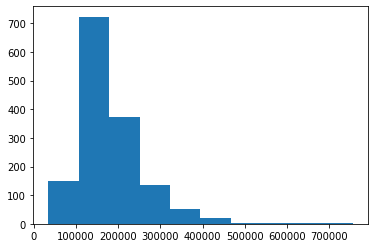

In [99]:
plt.hist(y_train,bins=10)

- 　a+1の対数当て正規分布に近づける
- 再度ヒストグラムで確認をしたところ、正規分布に近づいているのを確認

(array([  5.,  12.,  54., 184., 470., 400., 220.,  90.,  19.,   6.]),
 array([10.46027076, 10.76769112, 11.07511148, 11.38253184, 11.6899522 ,
        11.99737256, 12.30479292, 12.61221328, 12.91963363, 13.22705399,
        13.53447435]),
 <a list of 10 Patch objects>)

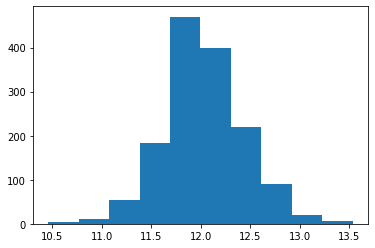

In [100]:
y_train = np.log1p(y_train)
plt.hist(y_train,bins=10)

## ■新たな特徴を作成
- 説明変数が多いので、似たような列を合わせて、回帰の予測に貢献しそうな列を作成
- １階、２階、地下室を合わせた総合的な部屋面積のtotalsize列の作成
- totalsizeを部屋数で割ったoneroomsize列を作成
- 築年数と、リホーム年数を合計したYearBuiltAndRemod列を作成
- 4つのbathの列からTotalBath列を作成
- porchに関連する変数を合計して、Totalporch列を作成
- プールの有無のhaspool、２階の有無のhas2ndfloor、ガレージの有無のhasgarage

In [101]:
alldata["totalsize"] = alldata["1stFlrSF"] + alldata["2ndFlrSF"] + alldata["TotalBsmtSF"]
alldata["oneroomsize"] =  alldata["totalsize"]/alldata["TotRmsAbvGrd"]
alldata['YearBuiltAndRemod']=alldata['YearBuilt']+alldata['YearRemodAdd']
alldata['Total_Bathrooms'] = (alldata['FullBath'] + (0.5 * alldata['HalfBath']) +
                               alldata['BsmtFullBath'] + (0.5 * alldata['BsmtHalfBath']))
alldata['Totalporch'] = (alldata['OpenPorchSF'] + alldata['3SsnPorch'] +
                              alldata['EnclosedPorch'] + alldata['ScreenPorch'] +
                              alldata['WoodDeckSF'])

## ■整数データと小数データを確認
-　数値データの散布図を作成して、相関関係を確認

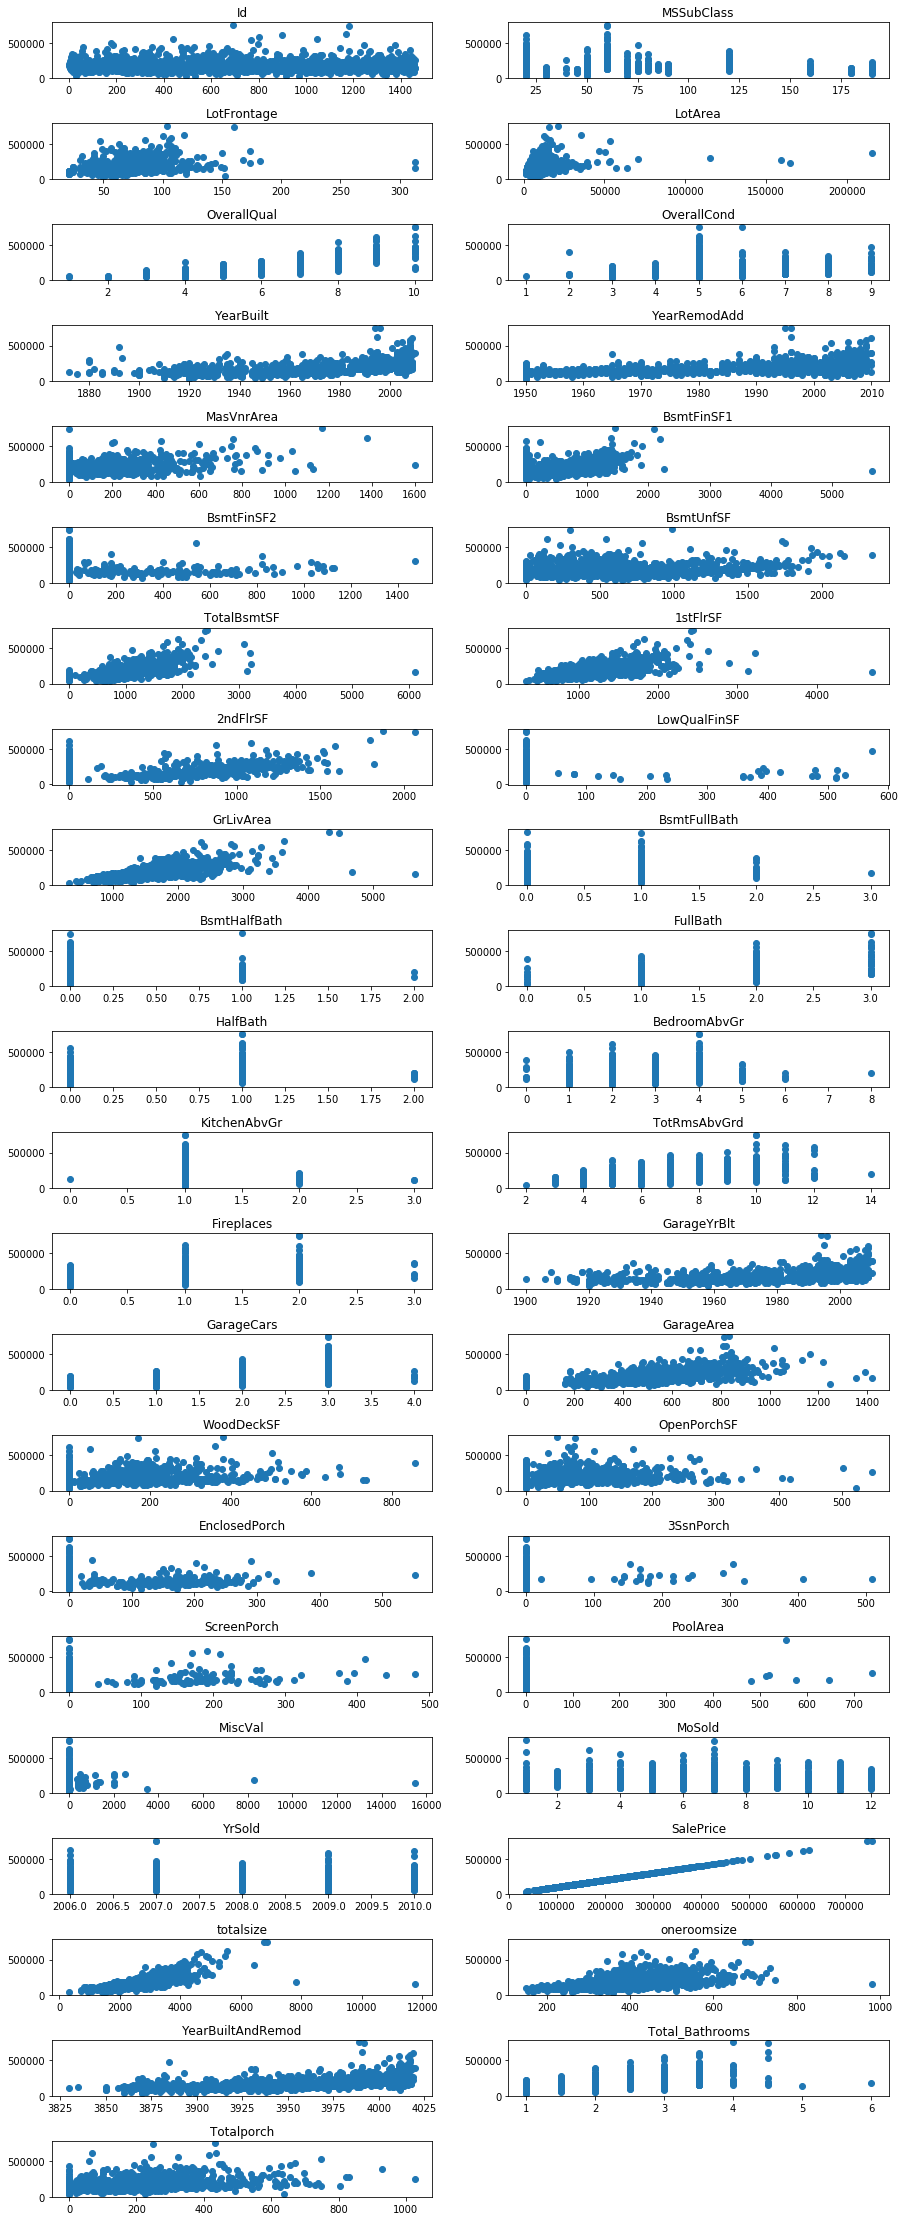

In [102]:
number_data = alldata.dtypes[alldata.dtypes !='object'].index
a= 0
plt.figure(figsize=(15, 40))
for column_name in alldata[number_data]:
    a = a+1
    plt.subplot(22,2,a)
    plt.subplots_adjust(hspace=0.8)
    plt.title(column_name)
    plt.scatter(alldata[column_name],alldataprice)

- 正の相関係数が高そうなグラフはいくつか存在するのを確認したが、相関関係が低い項目も確認
- 今回は決定木で予測するので、あまり相関がない列も残す
- 目的変数が極端に大きいが、SaleRriceが400000以下精度に影響がありそうな項目を中央値で埋める

In [103]:
alldata.loc[(alldata['LotFrontage'] >300 ) & (alldata['SalePrice'] <= 400000 ),['LotFrontage']]= alldata['LotFrontage'].median()
alldata.loc[(alldata['LotArea'] >100000 ) & (alldata['SalePrice'] <= 400000 ),['LotArea']]= alldata['LotArea'].median()
alldata.loc[(alldata['MasVnrArea'] >1000 ) & (alldata['SalePrice'] <= 400000 ),['MasVnrArea']]= alldata['MasVnrArea'].median()
alldata.loc[(alldata['BsmtFinSF1'] >4000 ) & (alldata['SalePrice'] <= 400000 ),['BsmtFinSF1']]= alldata['BsmtFinSF1'].median()
alldata.loc[(alldata['TotalBsmtSF'] >5000 ) & (alldata['SalePrice'] <= 400000 ),['TotalBsmtSF']]= alldata['TotalBsmtSF'].median()
alldata.loc[(alldata['1stFlrSF'] >4000 ) & (alldata['SalePrice'] <= 400000 ),['1stFlrSF']]= alldata['1stFlrSF'].median()
alldata.loc[(alldata['GrLivArea'] >4000 ) & (alldata['SalePrice'] <= 400000 ),['GrLivArea']]= alldata['GrLivArea'].median()
alldata.loc[(alldata['GarageArea'] >1200 ) & (alldata['SalePrice'] <= 400000 ),['GarageArea']]= alldata['GarageArea'].median()
alldata.loc[(alldata['oneroomsize'] >900 ) & (alldata['SalePrice'] <= 400000 ),['oneroomsize']]= alldata['oneroomsize'].median()
alldata.loc[(alldata['Totalporch'] >1000 ) & (alldata['SalePrice'] <= 400000 ),['Totalporch']]= alldata['Totalporch'].median()

## ■Objectデータの欠損を確認

- オブジェクトデータのそれぞれの列の欠損数を確認
- 欠損数が20より多い列のリスト、20以下の列のリストを作成する

In [104]:
small_na=[]
many_na=[]
object_data = alldata.dtypes[alldata.dtypes =='object'].index
for coulumns_name in alldata[object_data]:
    na_data = alldata[coulumns_name].isnull().sum()
    if 0< na_data <= 20:
        print(coulumns_name)
        print("欠損値",na_data)
        print(alldata[coulumns_name].unique())
        
        print("-"*100)
        small_na.append(coulumns_name)
    elif 20 < na_data:
        print(coulumns_name,'■欠損が多い')
        print("欠損値",na_data)
        print(alldata[coulumns_name].unique())
        print("-"*100)
        many_na.append(coulumns_name)

MSZoning
欠損値 4
['RL' 'RM' 'C (all)' 'FV' 'RH' nan]
----------------------------------------------------------------------------------------------------
Alley ■欠損が多い
欠損値 2721
[nan 'Grvl' 'Pave']
----------------------------------------------------------------------------------------------------
Utilities
欠損値 2
['AllPub' 'NoSeWa' nan]
----------------------------------------------------------------------------------------------------
Exterior1st
欠損値 1
['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock' nan]
----------------------------------------------------------------------------------------------------
Exterior2nd
欠損値 1
['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard' 'Plywood' 'Wd Sdng' 'CmentBd'
 'BrkFace' 'Stucco' 'AsbShng' 'Brk Cmn' 'ImStucc' 'AsphShn' 'Stone'
 'Other' 'CBlock' nan]
----------------------------------------------------------------------------------------------------
MasVnrType

- オブジェクトデータの欠損が20以下の列は、欠損の数量が少なく、度数への影響が少ないので最頻値で埋める

In [105]:
for coulumn_nanme in alldata[small_na]:
    print(coulumn_nanme)
    alldata[coulumn_nanme] = alldata[coulumn_nanme].fillna(alldata[coulumn_nanme].mode()[0])

MSZoning
Utilities
Exterior1st
Exterior2nd
Electrical
KitchenQual
Functional
SaleType


- 欠損値が多い列は、欠損を最頻値で埋めると度数が大きく変わりそうなので欠損も一つの特徴として、Noneを埋める

In [106]:
for coulumn_nanme in alldata[many_na]:
    print(coulumn_nanme)
    alldata[coulumn_nanme] = alldata[coulumn_nanme].fillna("None")

Alley
MasVnrType
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PoolQC
Fence
MiscFeature


## ■数値データの欠損を確認

- 数値データの欠損数を確認
- 欠損値があるリストを作成する

In [107]:
number_na=[]
for coulumns_name in alldata[number_data]:
    na_data = alldata[coulumns_name].isnull().sum()
    if na_data >0 :
        print(coulumns_name)
        print("欠損値",na_data)
        number_na.append(coulumns_name)
        print("-"*100)

LotFrontage
欠損値 486
----------------------------------------------------------------------------------------------------
MasVnrArea
欠損値 23
----------------------------------------------------------------------------------------------------
BsmtFinSF1
欠損値 1
----------------------------------------------------------------------------------------------------
BsmtFinSF2
欠損値 1
----------------------------------------------------------------------------------------------------
BsmtUnfSF
欠損値 1
----------------------------------------------------------------------------------------------------
TotalBsmtSF
欠損値 1
----------------------------------------------------------------------------------------------------
BsmtFullBath
欠損値 2
----------------------------------------------------------------------------------------------------
BsmtHalfBath
欠損値 2
----------------------------------------------------------------------------------------------------
GarageYrBlt
欠損値 159
----------------------------

- 数値の欠損は、価格の幅に影響が少ない、中央値で埋める

In [108]:
for coulumn_nanme in alldata[number_na]:
    print(coulumn_nanme)
    alldata[coulumn_nanme] = alldata[coulumn_nanme].fillna(alldata[coulumn_nanme].median())

LotFrontage
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
BsmtFullBath
BsmtHalfBath
GarageYrBlt
GarageCars
GarageArea
SalePrice
totalsize
oneroomsize
Total_Bathrooms


- 欠損値が埋まっているか確認

In [109]:
for coulumns_name in alldata:
    na_data = alldata[coulumns_name].isnull().sum()
    if na_data>0:
        print(coulumns_name)

## ■歪度が大きい説明変数の確認
- 歪度が0.75以上の数値の説明変数をヒストグラムで確認
- どれも右裾を引くヒストグラの形になっている

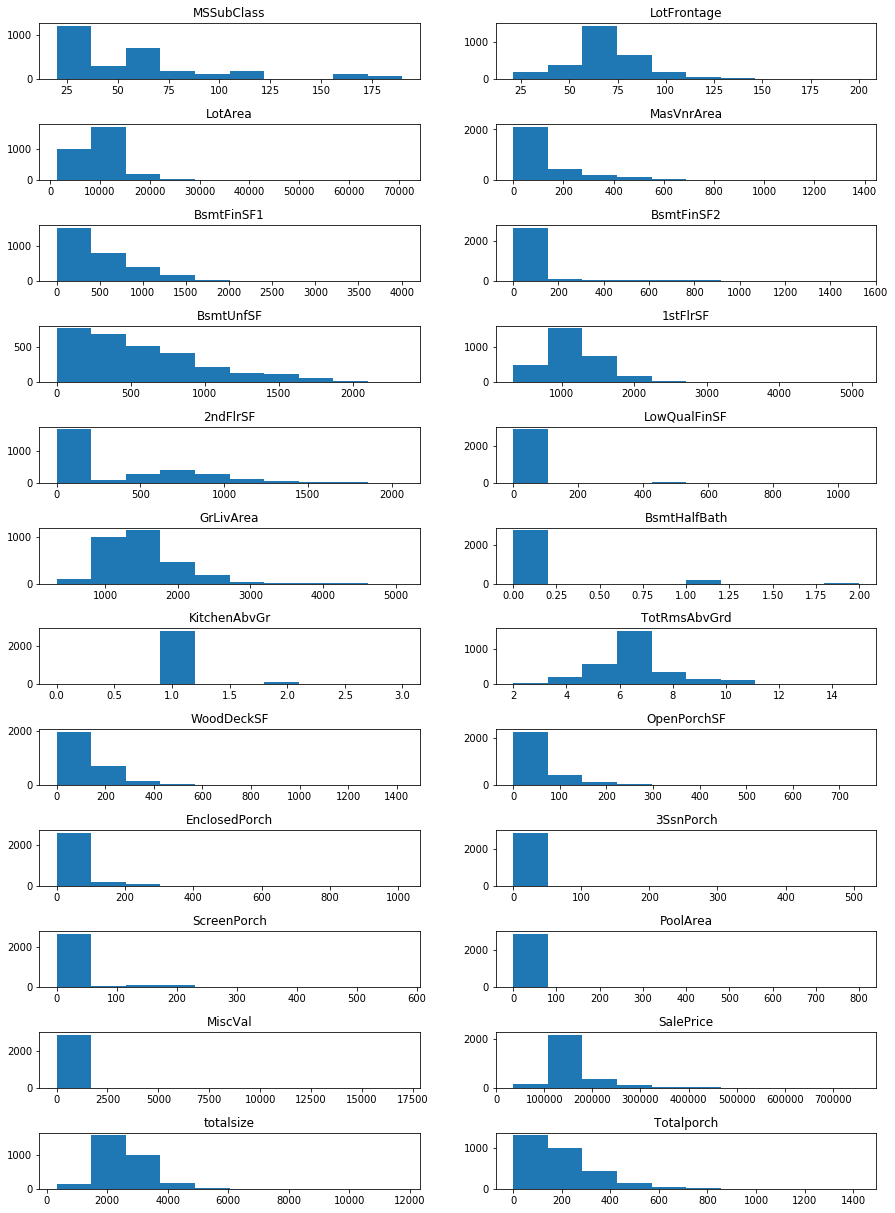

In [110]:
number_data = alldata.dtypes[alldata.dtypes !='object'].index
skewed = alldata[number_data].apply(lambda x: skew(x))
big_skewed = skewed[skewed > 0.75].index
a= 0
plt.figure(figsize=(15, 40))
for column_name in alldata[big_skewed]:
    a = a+1
    plt.subplot(22,2,a)
    plt.subplots_adjust(hspace=0.8)
    plt.title(column_name)
    plt.hist(alldata[column_name])

- 説明変数と同じく対数を当てて正規分布に近づける

In [111]:
alldata[big_skewed] = np.log1p(alldata[big_skewed])

- ヒストグラムで再度確認をする
- 中央が真ん中となる、正規分布に近づいた列もあれば、最頻値が多く占めている列はあまり変わりない

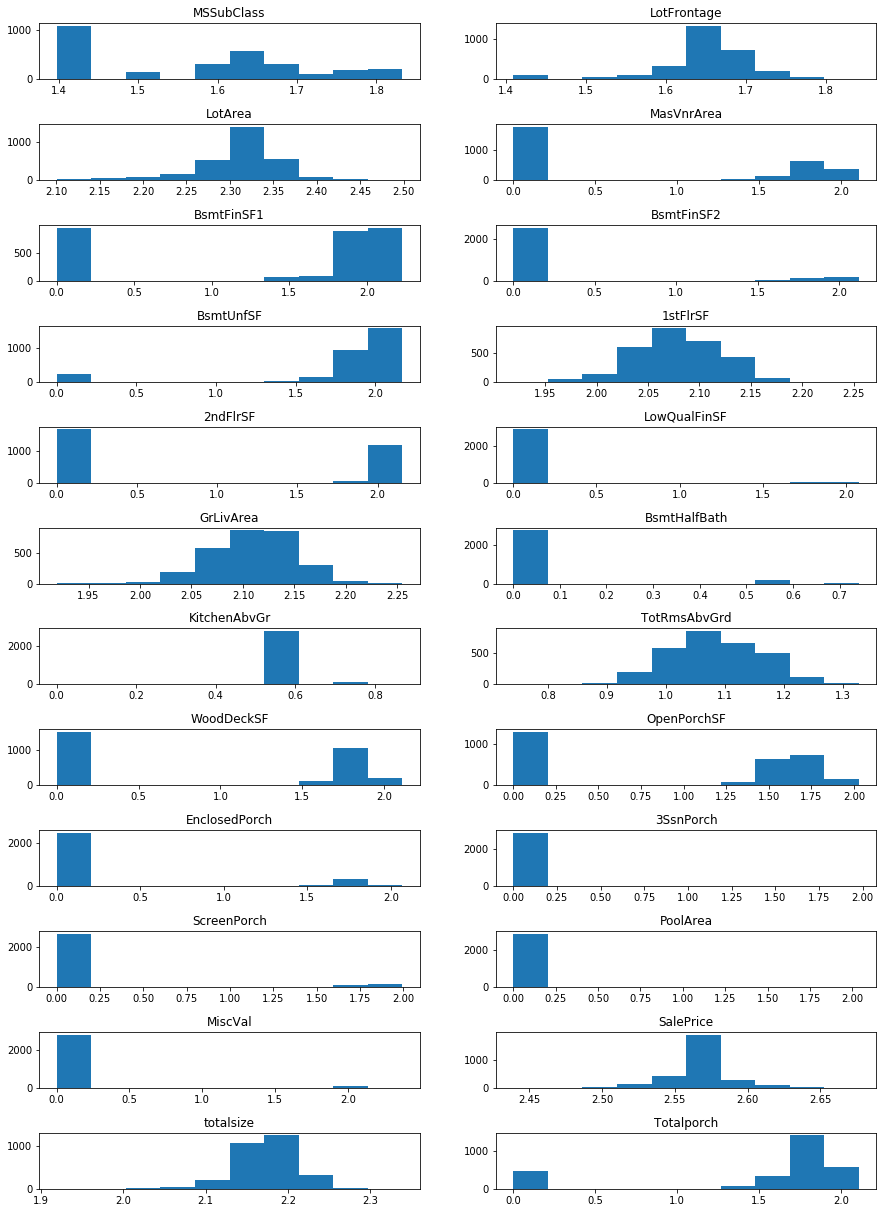

In [112]:
alldata[big_skewed] = np.log1p(alldata[big_skewed])
a= 0
plt.figure(figsize=(15, 40))
for column_name in alldata[big_skewed]:
    a = a+1
    plt.subplot(22,2,a)
    plt.subplots_adjust(hspace=0.8)
    plt.title(column_name)
    plt.hist(alldata[column_name])

## ■objectデータの加工
- objectdataは数値として扱わず、数値の大きさで予測がされないようにget_dummiesで１つの特徴ごとに列を作成する

In [113]:
object_data = alldata.dtypes[alldata.dtypes =="object"].index
alldata = pd.get_dummies(alldata)

## ■学習データと、testdataの分割

- alldataからラベルデータのSalePraice、idデータを削除

- 共通の データ加工が終わったので再度、trainデータとtestデータを分け,x_train,y_testとする
- traintest_test列も学習では使わないので削除

In [114]:
alldata_del_coulumns = ['SalePrice','Id']
alldata = alldata.drop(alldata_del_coulumns,axis=1)
x_train = alldata.query('traintest_test == 0')
x_test =  alldata.query('traintest_test == 1')
after_split_delcoulumns = ["traintest_test","traintest_train"]
x_train = x_train.drop(after_split_delcoulumns ,axis=1)
x_test = x_test.drop(after_split_delcoulumns ,axis=1)

- trainデータにあるが、testデータにないobjectdataを確認
- trainデータにあるが、testデータにないobjectデータを確認

In [115]:
delete_columns = []
for coulumn in x_train:
    x_train_unique = len(x_train[coulumn].unique())
    x_text_unique = len(x_test[coulumn].unique())
    if x_train_unique !=  x_text_unique:
        if x_train[coulumn].dtypes =="uint8":
            print(coulumn)
            delete_columns.append(coulumn)

Utilities_AllPub
Utilities_NoSeWa
Condition2_RRAe
Condition2_RRAn
Condition2_RRNn
HouseStyle_2.5Fin
RoofMatl_ClyTile
RoofMatl_Membran
RoofMatl_Metal
RoofMatl_Roll
Exterior1st_ImStucc
Exterior1st_Stone
Exterior2nd_Other
Heating_Floor
Heating_OthW
Electrical_Mix
GarageQual_Ex
PoolQC_Fa
MiscFeature_TenC


- 片方にしか特徴がないラベルデータを確認
- 学習に影響を与えそうなので、片方しかない列を削除する

In [116]:
x_train =x_train.drop(x_train[delete_columns],axis=1)
x_test =x_test.drop(x_test[delete_columns],axis=1)

- 線形専用の、x_train2,x_test2を作成する
- 線形の学習で1つのユニーク数が９９％以上占める列は学習に影響を与えそうなので削除

- 検証用データと学習用データに分ける

In [117]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train,y_train,test_size=0.3,random_state=3)

## ■RandomForestRegressorで機械学習で計算を行う

- グリッドサーチで学習に使うパラメータをセットする
- trainデータで学習を行う
- 検証用データで、y_Validを予測する

In [118]:
param_grid = {"max_depth": [3, 4,None],
              "n_estimators":[500,600,700],
              "min_samples_split": [2,3, 5],
              "min_samples_leaf": [2, 3, 5]}

In [119]:
randomforest_model =  GridSearchCV(RandomForestRegressor(),param_grid = param_grid, cv=5)
randomforest_model.fit(x_train,y_train)
price = randomforest_model.predict(x_valid)
submission1 = randomforest_model.predict(x_test)

## ■線形のLinearRegressionで機械学習を行う
- グリッドサーチで学習に使うパラメータをセットする
- train データで学習を行う
- 検証用データで、y_Validを予測する

In [120]:
param_grid= {"normalize": [True,False],
                         "fit_intercept":[True,False],
            }

In [121]:
linear_model = GridSearchCV(LinearRegression(),param_grid= param_grid,cv=5)
linear_model.fit(x_train,y_train)
price2 = linear_model .predict(x_valid)
submission2 = linear_model.predict(x_test)

## ■SVRで機械学習を行う
- グリッドサーチで学習に使うパラメータをセットする
- train データで学習を行う
- 検証用データで、y_Validを予測する

In [122]:
param_grid= {"epsilon": [0, 1, 10],
                         "C":[1,10,20,100],
                      "gamma": [1, 0.1, 0.01, 0.001],
            }

In [123]:
svr_model =  GridSearchCV(SVR(),param_grid = param_grid, cv=5)
svr_model.fit(x_train,y_train)
price3 = svr_model.predict(x_valid)
submission3 = svr_model.predict(x_test)

## ■LightGBMで機械学習を行う
- グリッドサーチで学習に使うパラメータをセットする
- train データで学習を行う
- 検証用データで、y_Validを予測する

In [124]:
param_grid= {
    "objective":["regression"],
        "n_estimators":[500,600,700],
             "max_depth":[None,3,4],
             "num_leaves":[3,5,10],
             "min_data_in_leaf ":[2,3,5],
             "min_samples_split": [2,3, 5],
            }

In [125]:
lgb_model =  GridSearchCV(lgb.LGBMRegressor(),param_grid = param_grid, cv=5)
lgb_model.fit(x_train,y_train)
price4 = lgb_model .predict(x_valid)
submission4 = lgb_model .predict(x_test)

## ■ 検証用データを確認
- 検証用データを真数に戻す
- R2スコア、二乗平均平方根誤差RMSEをそれぞれ確認する

In [126]:
y_valid = np.exp(y_valid)

## 【モデルの当てはまり度の仮説】
- 相関係数に考慮した列作成はしていない、多重共線性を考慮していないので、線形のLinearRegressionやSupport Vector Regressionはあまりモデルの予測は良くないかもしれない
- 決定木はあまり相関関係に影響がないので、アンサンブルや勾配ブースティングで学習を行うのでそこそこモデルの当てはまりは良いと予測

## 【モデルの当てはまり度結果】
- R2スコアを確認
- 決定木系は0.8超え
- Support Vector Regressionは予想通りの低さ
- LinearRegressionは正規化のパラメータ効いたのか、スコアはまさかの0.8超え

In [129]:
print("RandomForestRegressor")
r2_1 = r2_score(np.exp(price), y_valid)
print("r2スコア", r2_1)
print("LinearRegression")
r2_2 = r2_score(np.exp(price２), y_valid)
print("r2スコア", r2_2)
print("Support Vector Regression")
r2_3 = r2_score(np.exp(price3), y_valid)
print("r2スコア", r2_3)
print("LightGBM")

RandomForestRegressor
r2スコア 0.8436975306910526
LinearRegression
r2スコア 0.8578282087536689
Support Vector Regression
r2スコア -9.557063242241917
LightGBM


- それぞれの横棒グラフでそれぞれの二乗平均平方根誤差RMSEを確認する
- LightGBMが一番誤差が少ないのを確認
- LinearRegressionは正則化が効いたのか、決定木系とほぼ同じの誤差を確認
- Support Vector Regressionはモデルとしては、いまいちだったので、誤差が飛び抜けて大きい

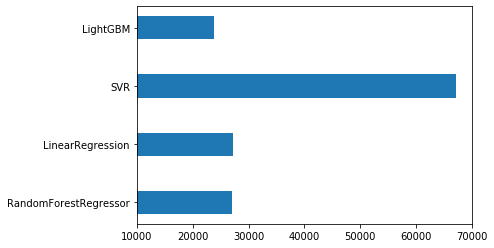

In [130]:
mse1 = mean_squared_error(np.exp(price),y_valid)
rmse1 =np.sqrt(mse1)
mse2 = mean_squared_error(np.exp(price2),y_valid)
rmse2 =np.sqrt(mse2)
mse3 = mean_squared_error(np.exp(price3),y_valid)
rmse3 =np.sqrt(mse3)
mse4 = mean_squared_error(np.exp(price4),y_valid)
rmse4 =np.sqrt(mse4)


plt.barh([0,1,2,3], [rmse1,rmse2,rmse3,rmse4], height=0.4, align="center")
plt.yticks([0,1,2,3],['RandomForestRegressor', 'LinearRegression', 'SVR','LightGBM'])
plt.xlim([10000,70000])
plt.xticks([10000,20000,30000,40000,50000,60000,70000])
plt.show()

- 一番精度が良かったLightGBMで提出データを作成
- IDは最初に作成した、変数submissioonidを使用する

In [133]:
submission = pd.DataFrame({
    "Id": submissioonid,
    "SalePrice":np.exp(submission4)
    })
submission.to_csv('houseplace.csv', index=False)

## ■提出結果

- 最高で上位25％に ![スコア](data/score.jpeg "スコア")